In [16]:
import pandas as pd
import os
from glob import glob

def load(pose_path: str, labels_path: str):
    """
    load data from csv files in the given path
    """
    # get labels
    df_labels = pd.read_csv(labels_path)

    # Get all CSV files in the folder
    csv_files = [ p for p in glob(os.path.join(pose_path, '*.csv'))]
    movie_names = [n.removeprefix(pose_path).removeprefix('/').removesuffix('.csv') + ".mp4" for n in csv_files]

    # filter out files that are not in the labels
    df_labels = df_labels[df_labels['movieName'].isin(movie_names)]

    # get labels for the movies
    movie_labels_dict = df_labels.set_index('movieName')['STYLE'].to_dict()
    movie_labels = [movie_labels_dict.get(n, 'Unknown') for n in movie_names]

    # Load and concatenate all CSV files into one DataFrame
    df = pd.concat(
        [pd.read_csv(f).assign(movie_name=n, style=l) for f,n,l in zip(csv_files, movie_names, movie_labels)],
        ignore_index=True
    )
    return df

df = load('../pose_outputs_loss', '../data/labeledFilms.csv')
df.head()


,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,movie_name,style
0,677.000000,297.000000,677.0,297.0,677.000000,297.000000,832.282715,424.533691,850.483032,428.466125,...,792.604858,561.561401,863.404846,569.667847,771.782104,610.205078,878.055664,619.091309,trimmed_noaudio20240224173004004_0.mp4,snowplow
1,851.287964,437.780212,680.0,294.0,849.370361,432.482971,680.000000,294.000000,840.466736,434.131042,...,851.289124,573.892700,813.992798,569.179565,869.699585,622.658081,802.528687,616.703125,trimmed_noaudio20240224173004004_0.mp4,snowplow
2,670.000000,301.000000,670.0,301.0,670.000000,301.000000,846.901794,435.319244,865.920776,438.161194,...,804.543274,573.923096,871.583496,579.968140,783.535950,622.502197,888.991760,631.533447,trimmed_noaudio20240224173004004_0.mp4,snowplow
3,686.000000,301.000000,686.0,301.0,686.000000,301.000000,856.719360,440.720337,686.000000,301.000000,...,814.114990,579.237671,883.382263,586.953979,792.458130,627.463928,900.482117,634.007812,trimmed_noaudio20240224173004004_0.mp4,snowplow
4,690.000000,304.000000,690.0,304.0,690.000000,304.000000,879.945190,443.308289,690.000000,304.000000,...,826.695679,588.380005,893.711548,596.905518,796.821045,634.917725,905.081299,645.603027,trimmed_noaudio20240224173004004_0.mp4,snowplow


# Normalizacja
Usunięcie pustych wierszy

In [17]:
# globals
keypoints_indexes = [str(i) for i in range(1,35)]
keypoints_indexes_x = [str(i) for i in range(1,35,2)]  # Assuming 17 keypoints
keypoints_indexes_y = [str(i) for i in range(2,35,2)]  # Assuming 17 keypoints


In [3]:
def remove_empty_rows(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove rows with NaN values in the DataFrame.
    Remove smaller than 40 records parts of data
    """
    delimiter_mask = df[keypoints_indexes].isnull().all(axis=1)

    # Get the indexes of delimiter rows
    delimiter_indices = df[delimiter_mask].index.tolist()

    # Add start and end for slicing
    all_indices = [-1] + delimiter_indices + [len(df)]

    # Split into chunks
    chunks = []
    for i in range(len(all_indices) - 1):
        start = all_indices[i] + 1
        end = all_indices[i + 1]
        chunk = df.iloc[start:end]
        if len(chunk) >= 40:
            chunks.append(chunk.reset_index(drop=True))

    # Concatenate all chunks into a single DataFrame
    return pd.concat(chunks, ignore_index=True)

df = load('../pose_outputs_loss', '../data/labeledFilms.csv')
print("Before cleanup:", df.last_valid_index())

df = remove_empty_rows(df)
print("After cleanup:", df.last_valid_index())
print(f"Are any nan values left? {df.isnull().values.any()}")

Before cleanup: 125086
After cleanup: 86329
Are any nan values left? False


Przesunięcie punktów pozycji na relatywne względem punktu pomiędzy prawym a lewym biodrem

In [4]:
def normalize_translation(df: pd.DataFrame):
    LEFT_HIP_X = "22"
    LEFT_HIP_Y = "23"
    RIGHT_HIP_X = "24"
    RIGHT_HIP_Y = "25"

    # calculate hip_center
    hip_center_x = (df[[LEFT_HIP_X, RIGHT_HIP_X]].mean(axis=1)).to_frame(name='hip_center_x')
    hip_center_y = (df[[LEFT_HIP_Y, RIGHT_HIP_Y]].mean(axis=1)).to_frame(name='hip_center_y')
    df = df.assign(hip_center_x=hip_center_x, hip_center_y=hip_center_y)

    # shift all keypoints relative to hip_center
    normalized = df.copy()
    normalized[keypoints_indexes_x] = df[keypoints_indexes_x] - hip_center_x.values
    normalized[keypoints_indexes_y] = df[keypoints_indexes_y] - hip_center_y.values
    return normalized


df = load('../pose_outputs_loss', '../data/labeledFilms.csv')
df.head()
translated_df = normalize_translation(df)
# Display the first few rows of the left and right hip columns to verify translation
translated_df.loc[:,["22", "24", "hip_center_x"]].head()
translated_df.loc[:,["23", "25", "hip_center_y"]].head()

,23,25,hip_center_y
0,274.731110,304.166840,821.054962
1,311.658600,294.983368,826.622223
2,282.307281,310.526154,837.919312
3,289.161743,318.973877,849.381042
4,307.346497,330.316040,868.644684


Przeskalowanie

In [5]:
import numpy as np

def normalize_scale(df: pd.DataFrame):
    LEFT_HIP_X = "22"
    LEFT_HIP_Y = "23"
    RIGHT_HIP_X = "24"
    RIGHT_HIP_Y = "25"

    # Compute reference distance (hip width)
    distance_x = df[RIGHT_HIP_X] - df[LEFT_HIP_X]
    distance_y = df[RIGHT_HIP_Y] - df[LEFT_HIP_Y]
    ref_distance = np.sqrt(distance_x**2 + distance_y**2)

    # # Avoid division by zero
    epsilon = 1e-6
    scale_factor = 1.0 / (ref_distance + epsilon)

    # Scale all keypoints
    normalized = df.copy()
    normalized[keypoints_indexes] = df[keypoints_indexes].mul(scale_factor, axis=0)
    return normalized

df = load('../pose_outputs_loss', '../data/labeledFilms.csv')
df = remove_empty_rows(df)
normalized = normalize_scale(df)
normalized.head()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,movie_name,style
0,3.021819,1.194673,3.021819,1.194673,3.021819,1.194673,3.021819,1.194673,3.021819,1.194673,...,4.248283,2.387563,3.969928,2.394027,4.291047,2.581842,3.856817,2.584860,trimmed_noaudio20240224173004004_0.mp4,beginner
1,3.038434,1.081051,3.038434,1.081051,3.038434,1.081051,3.849885,1.722293,3.038434,1.081051,...,3.736715,2.230313,3.984535,2.227282,3.639536,2.439309,4.073384,2.432365,trimmed_noaudio20240224173004004_0.mp4,beginner
2,3.232937,1.603178,3.262926,1.570565,3.205467,1.573153,3.318805,1.604582,2.649612,0.962150,...,2.649612,0.962150,2.649612,0.962150,2.649612,0.962150,2.649612,0.962150,trimmed_noaudio20240224173004004_0.mp4,beginner
3,83.001483,37.169218,83.173459,36.996628,69.117401,27.440420,69.117401,27.440420,69.117401,27.440420,...,83.395239,42.425653,82.068216,42.420174,83.565325,44.502326,81.966231,44.483457,trimmed_noaudio20240224173004004_0.mp4,beginner
4,38.637888,18.287175,38.829593,17.923232,38.368487,17.957230,39.130542,17.832854,37.989422,17.951373,...,39.168078,20.212588,37.824357,20.443150,39.083564,21.156470,37.855608,21.469689,trimmed_noaudio20240224173004004_0.mp4,beginner


Rotacja

In [6]:
def normalize_rotation(df: pd.DataFrame):
    LEFT_HIP_X = "22"
    LEFT_HIP_Y = "23"
    RIGHT_HIP_X = "24"
    RIGHT_HIP_Y = "25"

    vx = df[RIGHT_HIP_X] - df[LEFT_HIP_X]
    vy = df[RIGHT_HIP_Y] - df[LEFT_HIP_Y]
    angle = np.arctan2(vy, vx)

    x = df[keypoints_indexes_x].values  # shape (N, 17)
    y = df[keypoints_indexes_y].values  # shape (N, 17)

    # Compute sin and cos of angles
    cos_a = np.cos(angle.values.reshape(-1, 1))  # shape (N, 1)
    sin_a = np.sin(angle.values.reshape(-1, 1))  # shape (N, 1)

    # Apply rotation:
    # x' = x * cos - y * sin
    # y' = x * sin + y * cos
    x_rot = x * cos_a - y * sin_a
    y_rot = x * sin_a + y * cos_a

    # Build rotated DataFrame
    rotated = df.copy()
    rotated[keypoints_indexes_x] = x_rot
    rotated[keypoints_indexes_y] = y_rot

    return rotated

df = load('../pose_outputs_loss', '../data/labeledFilms.csv')
normalized = normalize_rotation(df)
normalized.head()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,movie_name,style
0,-610.718900,416.605839,-610.718900,416.605839,-610.718900,416.605839,-801.175252,480.667857,-814.157832,494.015823,...,-896.331490,374.384200,-940.736901,430.120294,-926.539565,330.941518,-990.411041,416.343328,trimmed_noaudio20240224173004004_0.mp4,beginner
1,934.921718,-205.582325,711.292670,-207.120105,930.066777,-208.440211,711.292670,-207.120105,924.258915,-201.493310,...,1021.713857,-100.731317,989.978019,-80.580233,1066.990945,-74.905115,1011.449942,-36.661318,trimmed_noaudio20240224173004004_0.mp4,beginner
2,-515.682085,523.042051,-515.682085,523.042051,-515.682085,523.042051,-703.243966,642.022911,-712.537705,658.858135,...,-818.387014,554.003876,-847.423238,614.731396,-856.595579,517.379536,-901.822453,613.071862,trimmed_noaudio20240224173004004_0.mp4,beginner
3,-495.424571,561.917694,-495.424571,561.917694,-495.424571,561.917694,-680.457913,682.040693,-495.424571,561.917694,...,-799.449187,599.316689,-827.871851,662.953539,-838.801376,564.015177,-877.897522,664.928484,trimmed_noaudio20240224173004004_0.mp4,beginner
4,-648.967548,383.871231,-648.967548,383.871231,-648.967548,383.871231,-872.833607,457.151256,-648.967548,383.871231,...,-959.753816,329.377274,-1005.712878,378.890662,-980.186893,277.989119,-1051.921478,359.773026,trimmed_noaudio20240224173004004_0.mp4,beginner


Zamiana na wartości od 0 do 1

In [7]:
def normalize_value(df: pd.DataFrame):
    """
    Normalize the values in the DataFrame to be between 0 and 1.
    """
    # Assuming the DataFrame contains only numeric columns
    min_values = df[keypoints_indexes].min(axis=1)
    max_values = df[keypoints_indexes].max(axis=1)
    # Avoid division by zero
    epsilon = 1e-6
    normalized_df = df.copy()
    subtracted_df = df[keypoints_indexes].sub(min_values, axis=0)

    normalized_df[keypoints_indexes] = subtracted_df.div(max_values - min_values + epsilon, axis=0)


    # Sprawdzić normalizacje do rozmiaru frame, a nie max narciarza
    return normalized_df

df = load('../pose_outputs_loss', '../data/labeledFilms.csv')
df = remove_empty_rows(df)
normalized = normalize_value(df)
normalized.head()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,movie_name,style
0,0.590092,0.000000,0.590092,0.000000,0.590092,0.000000,0.590092,0.000000,0.590092,0.000000,...,0.986189,0.385254,0.896292,0.387342,1.000000,0.447998,0.859762,0.448973,trimmed_noaudio20240224173004004_0.mp4,beginner
1,0.654133,0.000000,0.654133,0.000000,0.654133,0.000000,0.925309,0.214295,0.654133,0.000000,...,0.887490,0.384069,0.970308,0.383056,0.855014,0.453913,1.000000,0.451592,trimmed_noaudio20240224173004004_0.mp4,beginner
2,0.935782,0.264165,0.948141,0.250725,0.924462,0.251792,0.971168,0.264744,0.695397,0.000000,...,0.695397,0.000000,0.695397,0.000000,0.695397,0.000000,0.695397,0.000000,trimmed_noaudio20240224173004004_0.mp4,beginner
3,0.982595,0.172053,0.985637,0.169001,0.737056,0.000000,0.737056,0.000000,0.737056,0.000000,...,0.989559,0.265013,0.966091,0.264916,0.992567,0.301739,0.964287,0.301405,trimmed_noaudio20240224173004004_0.mp4,beginner
4,0.972718,0.150944,0.980460,0.136247,0.961840,0.137620,0.992612,0.132598,0.946533,0.137384,...,0.994128,0.228693,0.939868,0.238003,0.990715,0.266808,0.941129,0.279456,trimmed_noaudio20240224173004004_0.mp4,beginner


# Normalizacja kończyn
Każde osobno

Podsumowanie

In [8]:
def normalize_pose(frame_keypoints):
    steps = [
        remove_empty_rows,
        normalize_translation,
        normalize_scale,
        normalize_rotation,
        # Optional: normalize_limb for each limb
        normalize_value
    ]
    normalized = frame_keypoints.copy()
    for step in steps:
        normalized = step(normalized)
    return normalized
df = load('../pose_outputs_loss', '../data/labeledFilms.csv')
normalized = normalize_pose(df)


## Grupowanie danych w bloki

In [ ]:
def make_blocks(df, block_size=1000):
    X_sequences = []
    y = []
    for movie_name, group in df.groupby("movie_name"):
        coords = group.drop(columns=["movie_name", "style"]).values  # shape (T, D)

        if np.isnan(coords).all():
            print(f"Skipping group with NaN values for movie: {movie_name}")
            continue

        style = group["style"].iloc[0]

        # split coords into chunks of max block_size
        for start in range(0, len(coords), block_size):
            chunk = coords[start:start + block_size]
            X_sequences.append(chunk)
            y.append(style)


    return X_sequences, y

## Balansowanie zbiorów klas

In [ ]:
from random import choices
from collections import Counter

def balance_classes(train_X, train_y):
    counter = Counter(train_y)
    max_count = max(counter.values())

    # For each class, resample its sequences to match max_count
    augmented_X, augmented_y = [], []
    for cls in counter:
        cls_indices = [i for i, y in enumerate(train_y) if y == cls]
        # oversample with replacement
        selected = choices(cls_indices, k=max_count - len(cls_indices))
        for idx in cls_indices + selected:
            augmented_X.append(train_X[idx])
            augmented_y.append(cls)

    return augmented_X, augmented_y

# from random import choices
# from collections import Counter

# def balance_classes(train_X, train_y):
#     counter = Counter(train_y)
#     min_count = min(counter.values())

#     # For each class, downsample its sequences to match min_count
#     augmented_X, augmented_y = [], []
#     for cls in counter:
#         cls_indices = [i for i, y in enumerate(train_y) if y == cls]
#         # undersample without replacement
#         selected = choices(cls_indices, k=min_count)
#         for idx in selected:
#             augmented_X.append(train_X[idx])
#             augmented_y.append(cls)

#     return augmented_X, augmented_y


# DTW + k-NN
## Train

In [22]:
from tslearn.metrics import dtw
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.model_selection import train_test_split

# Prepare the data
df = load('../pose_outputs_loss', '../data/labeledFilms.csv')
normalized = normalize_pose(df)

# Suppose each sample is a (T, D) array: T=timesteps, D=features (e.g. 34 keypoints)
# You need to group rows per movie into a sequence
X_sequences, y = make_blocks(normalized)


for i, (coords, label) in enumerate(zip(X_sequences, y)):
    if coords.size == 0:
        print(f"Sequence {i} is empty! Label: {label}")
    elif np.isnan(coords).all():
        print(f"Sequence {i} is all NaN! Label: {label}")

# Split based on entire sequences
X_train_seq, X_test_seq, y_train, y_test = train_test_split(
    X_sequences, y, test_size=0.2, stratify=y, random_state=42
)

# balance classes
from collections import Counter
print(Counter(y_train))
X_train_seq, y_train = balance_classes(X_train_seq, y_train)
from collections import Counter
print(Counter(y_train))

# Convert to proper time series format (num_samples, T, D)
from tslearn.utils import to_time_series_dataset
X_train_ts = to_time_series_dataset(X_train_seq)
X_test_ts = to_time_series_dataset(X_test_seq)

# Train a classifier
knn = KNeighborsTimeSeriesClassifier(n_neighbors=12, metric="dtw")
knn.fit(X_train_ts, y_train)

y_pred = knn.predict(X_test_ts)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Counter({'skidded_short': 39, 'skidded_long': 20, 'snowplow': 18, 'carving_short': 17, 'carving_long': 6, 'quick': 2})
Counter({'carving_short': 39, 'snowplow': 39, 'skidded_long': 39, 'skidded_short': 39, 'carving_long': 39, 'quick': 39})
Accuracy: 0.11538461538461539

Classification Report:
                precision    recall  f1-score   support

 carving_long       0.00      0.00      0.00         2
carving_short       0.17      0.25      0.20         4
        quick       0.00      0.00      0.00         0
 skidded_long       0.11      0.20      0.14         5
skidded_short       0.50      0.10      0.17        10
     snowplow       0.00      0.00      0.00         5

     accuracy                           0.12        26
    macro avg       0.13      0.09      0.08        26
 weighted avg       0.24      0.12      0.12        26


Confusion Matrix:
 [[0 1 0 0 0 1]
 [1 1 2 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 1 1 2]
 [1 1 0 6 1 1]
 [1 2 0 2 0 0]]


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Evaluate

### Confusion Matrix

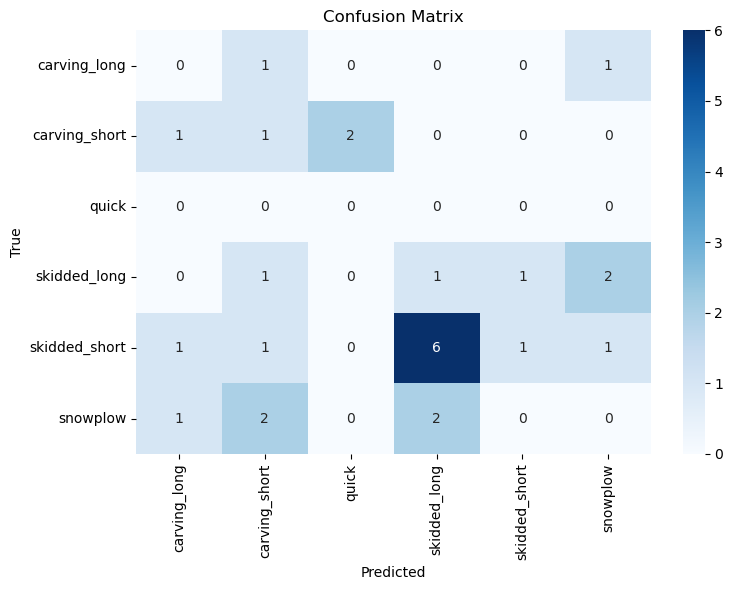

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=sorted(set(y)))
labels = sorted(set(y))

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

### Per-Class Accuracy Bar Plot

/var/folders/7j/_mf7cz993nvdqnr770m9bht40000gn/T/ipykernel_31844/3974277731.py:4: RuntimeWarning: invalid value encountered in divide
  class_accuracy = cm.diagonal() / cm.sum(axis=1)


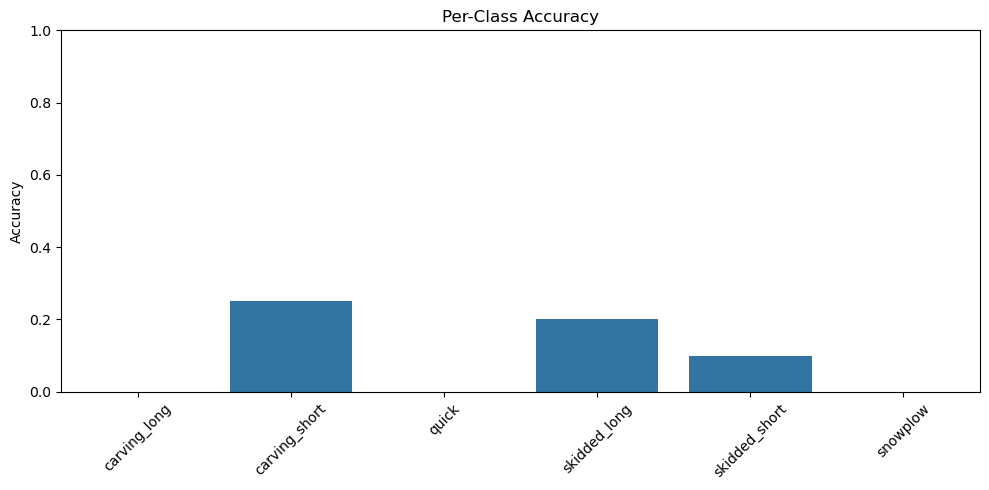

In [24]:
import numpy as np

cm = confusion_matrix(y_test, y_pred, labels=labels)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(10, 5))
sns.barplot(x=labels, y=class_accuracy)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# LSTM (TODO)
## Trening

In [13]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# load the data
df = load('../pose_outputs_loss', '../data/labeledFilms.csv')
df['style'] = df['style'].astype(str)  # ensure it's str (for label encoding)

# Prepare the data
SEQUENCE_LENGTH = 40  # truncate or pad to this length
FEATURE_SIZE = len(df.columns) - 2  # exclude 'style' and 'movie_name'
sequences = []
labels = []

for movie_name, group in df.groupby("movie_name"):
    group = group.drop(columns=["movie_name"])  # keep only keypoints + label
    label = group['style'].iloc[0]  # assume label same for the whole clip
    keypoints = group.drop(columns=['style']).values.astype(np.float32)

    # Truncate or pad
    if len(keypoints) >= SEQUENCE_LENGTH:
        keypoints = keypoints[:SEQUENCE_LENGTH]
    else:
        pad_len = SEQUENCE_LENGTH - len(keypoints)
        padding = np.zeros((pad_len, keypoints.shape[1]), dtype=np.float32)
        keypoints = np.vstack((keypoints, padding))

    sequences.append(keypoints)
    labels.append(label)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
X = np.array(sequences, dtype=np.float32)
y = np.array(y, dtype=np.int64)
print(f"X shape: {X.shape}, y shape: {y.shape}")  # (n_clips, seq_len, features)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)
X_train_seq, y_train = balance_classes(X_train, y_train)

class PoseSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(PoseSequenceDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(PoseSequenceDataset(X_val, y_val), batch_size=32)

class LSTMPoseClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        return self.fc(out)

# Initialize the model, loss function, and optimizer
input_size = X.shape[2]
model = LSTMPoseClassifier(input_size=input_size, hidden_size=64, num_classes=len(le.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    for X_batch, y_batch in train_loader:
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


X shape: (77, 40, 34), y shape: (77,)
Epoch 1, Loss: nan
Epoch 2, Loss: nan
Epoch 3, Loss: nan
Epoch 4, Loss: nan
Epoch 5, Loss: nan
Epoch 6, Loss: nan
Epoch 7, Loss: nan
Epoch 8, Loss: nan
Epoch 9, Loss: nan
Epoch 10, Loss: nan


## Ewaluacja

In [14]:
model.eval()
correct = total = 0
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        preds = model(X_batch)
        predicted = preds.argmax(dim=1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

print("Validation Accuracy:", correct / total)

Validation Accuracy: 0.1875


Podzielić filmiki na fragmenty mniejsze
Sprawdź jak długie są filmiki i o ile się różnią, jak o dużo to podziel na bloki

Można wykres accuracy od ilości n_neigh dla knn